<a href="https://colab.research.google.com/github/coderhetal/NLP/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Packages

Run this cell only if torchtext reports an error while importing bleu_score.

In [1]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


##Importing Required Libraries




In [3]:
from google.colab import drive
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import numpy as np
import random
import spacy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


Fixing SEED for reproducibility of results

In [20]:
SEED = 4444

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Fetching Spacy Models

In [21]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [1]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-07-07 12:37:10.744083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 12:37:12.642723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-07 12:37:15.272204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 12:37:15.275976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## Helper Objects and Functions

In [4]:
de_model = spacy.load('de_core_news_sm')
en_model = spacy.load('en_core_web_sm')


Unlike the paper, reversing the input sequence resulted in a lower BLEU Score. Hence, the input sequences have not been reversed.

In [6]:
def de_tokenizer(sentence):
    return [token.text for token in de_model.tokenizer(sentence)]

def en_tokenizer(sentence):
    return [token.text for token in en_model.tokenizer(sentence)]

In [7]:
SOURCE_Field = Field(eos_token = '<src_eos>', init_token = '<src_sos>', lower = True, tokenize = de_tokenizer)

TARGET_Field = Field(eos_token = '<trg_eos>', init_token = '<trg_sos>', lower = True, tokenize = en_tokenizer)

A helper function to return an input tensor corresponding to any string or list of tokens.

In [39]:
def ipTensor(sentence, src_field):
    if isinstance(sentence, list):
        tokens = [src_field.init_token] + [token.lower() for token in sentence] + [src_field.eos_token]
    else:
        tokens = [src_field.init_token] + de_tokenizer(sentence) + [src_field.eos_token]
    seq_len = len(tokens)
    print(seq_len)
    ip_tensor = torch.LongTensor([src_field.vocab.stoi[token] for token in tokens]).to(device)
    return ip_tensor.view(seq_len, 1)

## Fetching and Splitting Data

In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SOURCE_Field, TARGET_Field))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 576kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 177kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 168kB/s]


In [10]:
SOURCE_Field.build_vocab(train_data, min_freq = 2)
TARGET_Field.build_vocab(train_data, min_freq = 2)


In [11]:
print(f"Source vocab size: {len(SOURCE_Field.vocab)} | Target vocab size: {len(TARGET_Field.vocab)}")

Source vocab size: 7853 | Target vocab size: 5893


## Model Definition

In [12]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, enc_dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # creates an embedding layer (nn.Embedding) named embedding. This layer is used to map the input word indices to their corresponding dense embeddings.
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=enc_dropout)
        self.dropout = nn.Dropout(enc_dropout)

    def forward(self, input):
      #here input is the vector with indices of the words in vocabulary
        embedding = self.dropout(self.embedding(input))                         # input = [seq_len, batch_size]  embedding = [seq_len, batch_size, embedding_dim]
        output, states = self.rnn(embedding)                                    # output = [seq_len, batch_size, num_directions*hidden_dim]   **Here number of directions is 1
                                                                                # states = (hidden, cell) = [num_layers*num_directions, batch_size, hidden_dim]
        return states

In [13]:
#This Decoder module is responsible for generating the translated sentence word by word,
 #taking the input word indices, the previous hidden and cell states, and producing the
 #predicted word probabilities at each time step.

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dec_dropout):
      #num_layers is no  of layers in lstm
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dec_dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dec_dropout)

    def forward(self, input, states):
        embedding = self.dropout(self.embedding(input))                         # input = [1, batch_size]  embedding = [1, batch_size, embedding_dim]
        output, states = self.rnn(embedding, states)                            # output = [seq_len, batch_size, num_directions*hidden_dim]   **Here number of directions is 1
        output = self.fc(output).unsqueeze(0)                                   # output = [seq_len, batch_size, vocab_size]
        # unsqueeze:adds an additional dimension at index 0 to match the expected shape of the output tensor.
        return output, states

The Seq2Seq model combines the encoder and decoder modules to perform the translation task. It uses the encoder to process the input source sentence and the decoder to generate the translated target sentence word by word, either using teacher forcing or the previous predicted word, depending on the specified ratio.

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio):
        enc_states = self.encoder(source)                                       # source = [seq_len, batch_size]
                                                                                # target = [seq_len, batch_size]
        dec_states = enc_states
        seq_len = target.shape[0]
        print(seq_len)
        batch_size = target.shape[1]
        predictions = torch.zeros(seq_len, batch_size, self.decoder.output_dim).to(device)
        input = target[0,:].unsqueeze(0)                                        # input = [1, batch_size]
        #sets the initial input for the decoder to be the first target word
        # in the target sentence. The unsqueeze(0) operation adds an additional
        #dimension at index 0 to match the expected shape.
        for t in range(1, seq_len):
            output, dec_states = self.decoder(input, dec_states)
            #passes the input and decoder states to the decoder module,
            #obtaining the output predictions and updated decoder states.
            output = output.squeeze()
            # removes the extra dimension from the output tensor.
            predictions[t] = output.view(batch_size, self.decoder.output_dim)
            if random.random() < teacher_forcing_ratio:
                input = target[t].unsqueeze(0)
            else:
                input = output.argmax(1).unsqueeze(0)

        return predictions[1:]

## Training and Evaluation Functions

```teacher_forcing_ratio``` is the probability of using the ground truth tokens as inputs while decoding. It is usually set to 1 while training and 0 while sampling. However, setting it to 0.5 resulted in a better BLEU Score than setting it to 1.


The Train function carries out the training process for the Seq2Seq model by iterating over the data batches, performing forward and backward passes, updating the model parameters, and computing the loss. The average epoch loss is returned as an indication of the model's performance during training.

In [15]:
def Train(iterator, model, criterion, optimizer, clip=1):
    model.train()
    epoch_loss = 0
    for _, batch in enumerate(iterator):
        model.zero_grad()# clears the gradients of the model parameters before starting the backward pass.
        source = batch.src
        target = batch.trg
        #extract the source and target sentences from the batch.
        outputs = model(source, target, teacher_forcing_ratio=0.5)
        outputs = outputs.view(-1, outputs.shape[-1])
        targets = target[1:].view(-1)
        batch_loss = criterion(outputs, targets.to(device))
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # clips the gradients to prevent them from exceeding the specified clip value,
        #which helps mitigate the exploding gradient problem.
        optimizer.step()
        epoch_loss += batch_loss.item()

    return epoch_loss/len(iterator)  #function returns the average epoch loss,

In [16]:
def Evaluate(iterator, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            model.zero_grad()
            source = batch.src
            target = batch.trg
            outputs = model(source, target, 0)
            #teacher forcing ratio is set to 0, meaning the model relies solely on its own predictions without using the actual target words.
            outputs = outputs.view(-1, outputs.shape[-1])
            targets = target[1:].view(-1)
            batch_loss = criterion(outputs, targets.to(device))
            eval_loss += batch_loss.item()

        return eval_loss/len(iterator)

In [17]:
def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

## Data Iterators, Hyperparameters and Model Initialization

In [23]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

In [24]:
print("Number of Training sequences: ", len(train_data.examples))
print("Number of Test sequences: ", len(test_data.examples))
print("Number of Validation sequences: ", len(valid_data.examples))

Number of Training sequences:  29000
Number of Test sequences:  1000
Number of Validation sequences:  1014


In [25]:
CLIP = 1
NUM_EPOCHS = 20
LR = 0.001
HIDDEN_DIM = 512
SRC_VOCAB_SIZE = len(SOURCE_Field.vocab)
TRG_VOCAB_SIZE = len(TARGET_Field.vocab)
EMBEDDING_DIM = 256
NUM_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [26]:
target_padding_index = TARGET_Field.vocab.stoi[TARGET_Field.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = target_padding_index)

In [27]:
encoder = Encoder(SRC_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DEC_DROPOUT).to(device)
seq2seq = Seq2Seq(encoder, decoder).to(device)
optimizer = optim.AdamW(seq2seq.parameters(), LR)

In [28]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [29]:
seq2seq.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters.')

The model has 13,898,501 trainable parameters.


## Training


Perplexity measures the average uncertainty or unpredictability of an event. In the context of language modeling, perplexity is a way to estimate the average number of choices or possibilities that a language model assigns to each word in a given sequence.

Mathematically, perplexity is defined as the exponentiated average negative log-likelihood per word:

Perplexity = exp(∑(-log(p(w_i)))) / N

where:

∑(-log(p(w_i))) is the sum of the negative log-probabilities of each word in the sequence, representing the average uncertainty.
N is the total number of words in the sequence.
A lower perplexity indicates that the language model is more confident in its predictions, assigning higher probabilities to the correct words. A higher perplexity means that the language model is less certain, assigning lower probabilities to the correct words.

In [31]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}")
train_losses = []
valid_losses = []
prev_epoch = 1
min_losses = [float('inf'), float('inf')]
start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = Train(train_iterator, seq2seq, criterion, optimizer, CLIP)
    train_losses.append(train_loss)
    valid_loss = Evaluate(test_iterator, seq2seq, criterion)
    valid_losses.append(valid_loss)
    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss

    if epoch % int(NUM_EPOCHS / 10) == 0:
        elapsed_time = Epoch_time(start_time, time.time())
        print(f"Time taken for epochs {prev_epoch} to {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
        start_time = time.time()
        prev_epoch = epoch + 1
        print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
        print(f"Training PPL: {math.exp(train_loss):.4f} | Validation PPL: {math.exp(valid_loss):.4f}")
print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001, Hidden Dimensions: 512
Time taken for epochs 1 to 2: 1m 20s
Training Loss: 4.5169 | Validation Loss: 4.8918
Training PPL: 91.5469 | Validation PPL: 133.1889
Time taken for epochs 3 to 4: 1m 19s
Training Loss: 3.9789 | Validation Loss: 4.4666
Training PPL: 53.4602 | Validation PPL: 87.0625
Time taken for epochs 5 to 6: 1m 22s
Training Loss: 3.6014 | Validation Loss: 4.1094
Training PPL: 36.6489 | Validation PPL: 60.9099
Time taken for epochs 7 to 8: 1m 26s
Training Loss: 3.2781 | Validation Loss: 3.7789
Training PPL: 26.5253 | Validation PPL: 43.7696
Time taken for epochs 9 to 10: 1m 22s
Training Loss: 2.9875 | Validation Loss: 3.7766
Training PPL: 19.8365 | Validation PPL: 43.6652
Time taken for epochs 11 to 12: 1m 30s
Training Loss: 2.7494 | Validation Loss: 3.6831
Training PPL: 15.6329 | Validation PPL: 39.7678
Time taken for epochs 13 to 14: 1m 22s
Training Loss: 2.5582 | Validation Loss: 3.5637
Training PPL: 12.9132 | Validation PPL: 35.2929
Time taken for epo

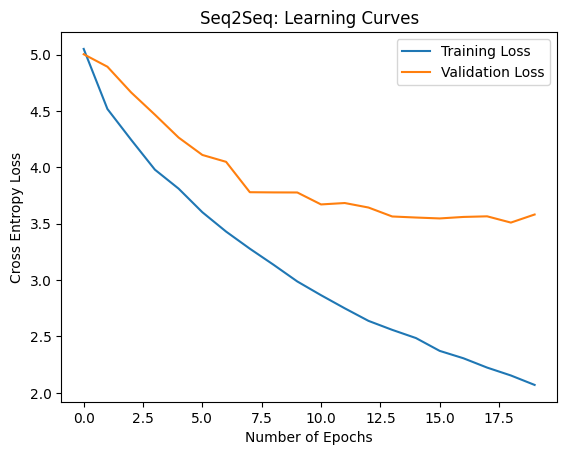

In [32]:
plt.title("Seq2Seq: Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label= "Validation Loss")
plt.legend()
plt.show()


## Sampling

Run the cell below to load the model for sampling.


In [33]:
seq2seq.eval()
test_loss = Evaluate(test_iterator, seq2seq, criterion)
print(f"Test Loss: {test_loss:.4f} | Test PPL: {math.exp(test_loss):.4f}")

Test Loss: 3.5812 | Test PPL: 35.9166


In [34]:
def Translate(src_sentence, src_field, trg_field, model):
    ip_tensor = ipTensor(src_sentence, src_field)
    max_len = 4*ip_tensor.shape[0]
    src_len = [ip_tensor.shape[0]]
    with torch.no_grad():
        enc_states = model.encoder(ip_tensor)
    dec_states = enc_states
    sos_id = trg_field.vocab.stoi[trg_field.init_token]
    eos_id = trg_field.vocab.stoi[trg_field.eos_token]
    predicts = [sos_id]
    len = 1
    while len < max_len:
        input = torch.LongTensor([predicts[-1]]).view((1, 1)).to(device)
        with torch.no_grad():
            output, dec_states = model.decoder(input, dec_states)
        output = output.squeeze()
        output = output.view(-1, model.decoder.output_dim)
        predicts.append(output.argmax(-1).item())
        len += 1
        if predicts[-1] == eos_id:
            break
    sentence = [trg_field.vocab.itos[id] for id in predicts[1:]]
    return sentence

In [41]:
ind = int(random.random() * len(test_data.examples))
example = test_data.examples[ind]
src_sentence = example.src
trg_sentence = example.trg
print("German Sentence: ", ' '.join(src_sentence))
translation = Translate(src_sentence, SOURCE_Field, TARGET_Field, seq2seq)
print("Predicted Translation: ", ' '.join(translation[:-1]))
print("Actual Translation: ", ' '.join(trg_sentence))

German Sentence:  eine gruppe von läufern läuft auf zwei identische wolkenkratzer zu .
13
Predicted Translation:  a group of runners are running the race with two flags .
Actual Translation:  a group of runners are running towards two identical skyscrapers .


## BLEU Score

In [36]:
def Calculate_BLEU(data, src_field, trg_field, model):
    trgs = []
    predicted_trgs = []
    for i in range(len(data.examples)):
        src_sentence = vars(data[i])['src']
        trg_sentence = vars(data[i])['trg']
        try:
            # Sometimes(rarely) CUDA throws a "Device side assert triggered" error. So, just to avoid restarting runtime.
            predicted_trg = Translate(src_sentence, src_field, trg_field, model)
            predicted_trgs.append(predicted_trg[:-1])
            trgs.append([trg_sentence])
        except:
            pass
    return bleu_score(predicted_trgs, trgs)

#input sequences and target sequences often have different lengths.
#To process them efficiently in batches, padding is introduced to make
#all sequences within a batch have the same length.

In [37]:
bleu_score_test = Calculate_BLEU(test_data, SOURCE_Field, TARGET_Field, seq2seq)
print(f"BLEU score on Testing Data: {bleu_score_test*100:.2f}")

BLEU score on Testing Data: 20.47
